In [228]:
import pyvisa
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

In [229]:
# N = 15       # number of loops
# lc = 0.12     # magnetic core length / m
# l = 7e-2
# w = 18e-6 * 4
N = 19       # number of loops
lc = 6.6e-2*np.pi     # magnetic core length / m
l = 7.7e-2
w = 18e-6 * 4
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2
fre = 4      # current frequency
T = 5       # measure time
# R = 1 * 3.6 / 6  # resistance calculate
R = 1.25
gain = 15
samp_rate = 5000
n_sample = samp_rate * T
dt = 1/samp_rate

In [230]:
def test_func(x, a ,b, c):
    return a * np.sin(b *2*np.pi* x + c)

def sin_fit(raw_data, Vset, fre, time_data):
    #x_data = np.linspace(0 , time_mea, len(raw_data))
    x_data = np.array(time_data)
    y_data = np.array(raw_data)
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[0.5,fre,0])
    # plt.plot(x_data, y_data, '.', label='Data')
    # plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),label='Fitted function',color = "r")
    # plt.legend(loc='best')
    # plt.show()
    return params, x_data

def off_subtract(Vin,Vpick):
    input_off_mea = np.mean(Vin[1000:5000])
    Vin_sub = Vin - input_off_mea
    pick_off_mea = np.mean(Vpick[1000:5000])
    Vpick_sub = Vpick - pick_off_mea
    return Vin_sub, Vpick_sub

In [231]:
fname = "C:\\Users\\CeNTREX\\Documents\\GitHub\\new_cavity\\minorloop_4_10_2024.hdf"
Vin = []
Vpick = []
Vin_used = []
Vpick_used = []
Vamp = [0.1,0.2,0.5,0.7,1,1.5,2,3,4,5,6,7,8,9,10]
with h5py.File(fname, "a") as f:
    for i in Vamp:
        dset = f[f"{i}Vpp"]
        Vin.append(dset[0])
        Vpick.append(dset[1])
        
time_stamp = np.linspace(0,T,len(Vin[0]))


In [232]:
time_mea = []
Vin_mea  = []
Vpick_mea = []
for i in range(len(Vamp)):
    Vin_used, Vpick_used = off_subtract(Vin[i],Vpick[i])
    pos_peaks,_ = find_peaks(Vpick_used,distance=1000, height = max(Vpick_used)*0.9)
    time_mea.append(time_stamp[pos_peaks[0]:-1])
    Vin_mea.append(Vin_used[pos_peaks[0]:-1])
    Vpick_mea.append(Vpick_used[pos_peaks[0]:-1])


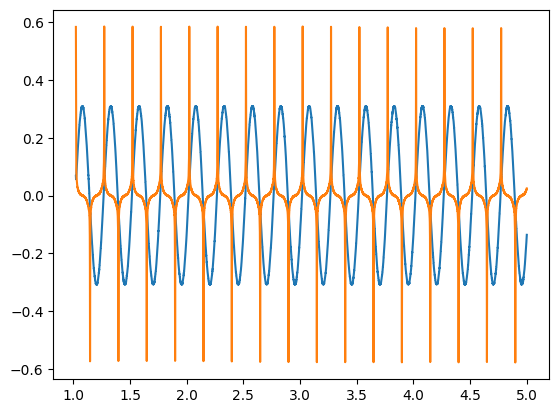

In [233]:
plt.plot(time_mea[-1],Vin_mea[-1])
plt.plot(time_mea[-1],Vpick_mea[-1])

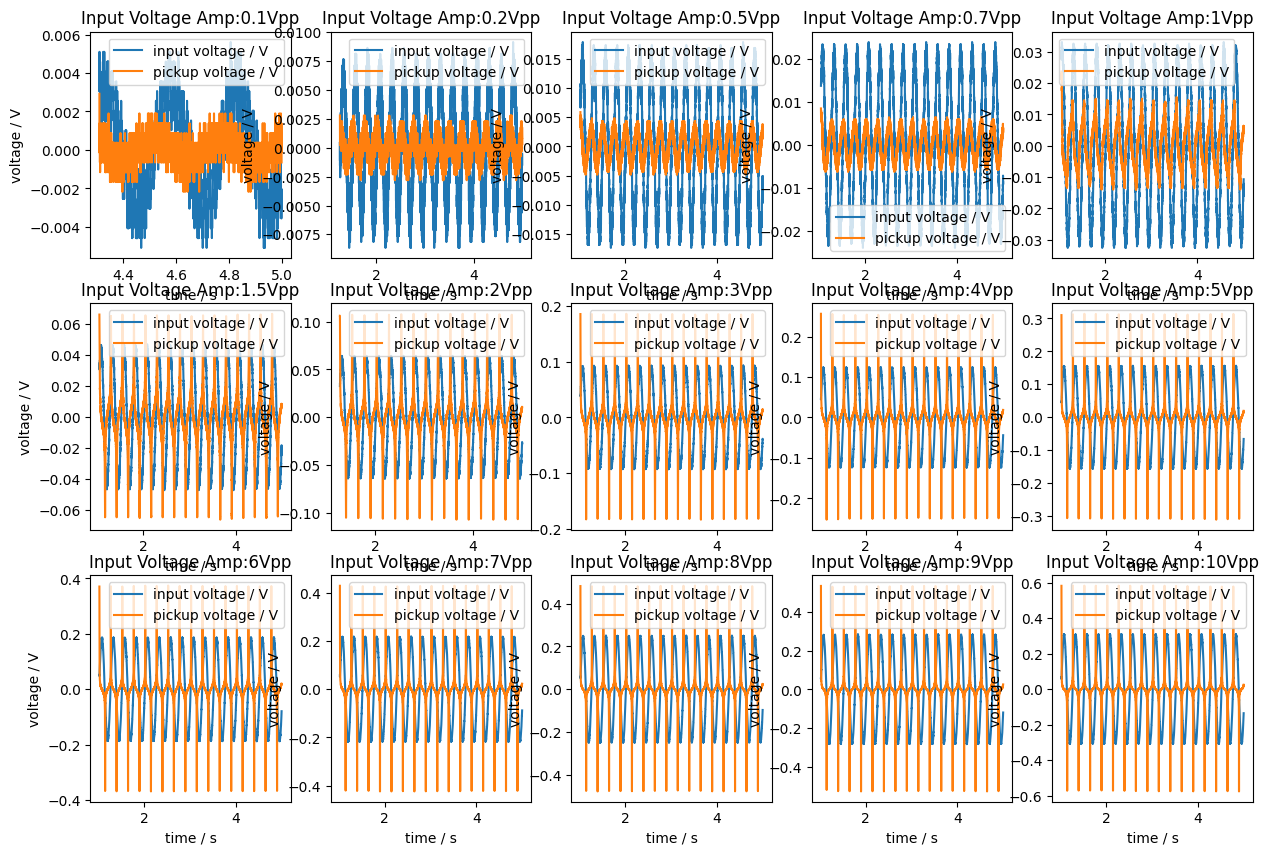

In [234]:
fig, ax = plt.subplots(3,5,figsize=(15, 10))
for i in range(len(Vamp)):
    if i < 5 :
        ax[0,i].plot(time_mea[i],Vin_mea[i], label = "input voltage / V")
        ax[0,i].plot(time_mea[i],Vpick_mea[i], label = "pickup voltage / V")
        ax[0,i].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[0,i].set_xlabel("time / s")
        ax[0,i].set_ylabel("voltage / V")
        ax[0,i].legend()
    elif i < 10:
        ax[1,i-5].plot(time_mea[i],Vin_mea[i], label = "input voltage / V")
        ax[1,i-5].plot(time_mea[i],Vpick_mea[i], label = "pickup voltage / V")
        ax[1,i-5].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[1,i-5].set_xlabel("time / s")
        ax[1,i-5].set_ylabel("voltage / V")
        ax[1,i-5].legend()
    else:
        ax[2,i-10].plot(time_mea[i],Vin_mea[i], label = "input voltage / V")
        ax[2,i-10].plot(time_mea[i],Vpick_mea[i], label = "pickup voltage / V")
        ax[2,i-10].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[2,i-10].set_xlabel("time / s")
        ax[2,i-10].set_ylabel("voltage / V")
        ax[2,i-10].legend()


In [235]:
amp_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
for i in range(len(Vamp)):
    param,x = sin_fit(Vin_mea[i],Vamp[i],4,time_mea[i])
    amp_fit.append(param[0])
    fre_fit.append(param[1])
    phase_fit.append(param[2])
    if param[0] > 0:
        V_SGamp.append((2 * Vamp[i] - 2*abs(param[0]))/2)
    else:
        V_SGamp.append((-1* (2 * Vamp[i] - 2*abs(param[0])))/2)

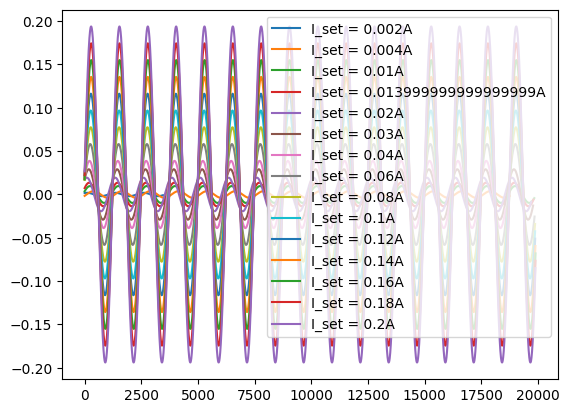

In [236]:
I = []
I_set = np.array(Vamp)/50
I_SGamp = np.array(V_SGamp)/50
for i in range(len(Vamp)):
    V_SG = test_func(time_mea[i], V_SGamp[i], param[1],param[2])
    I.append(V_SG /50)
    plt.plot(I[i], label  = "I_set = "+ str(I_set[i]) + "A")
    plt.legend()


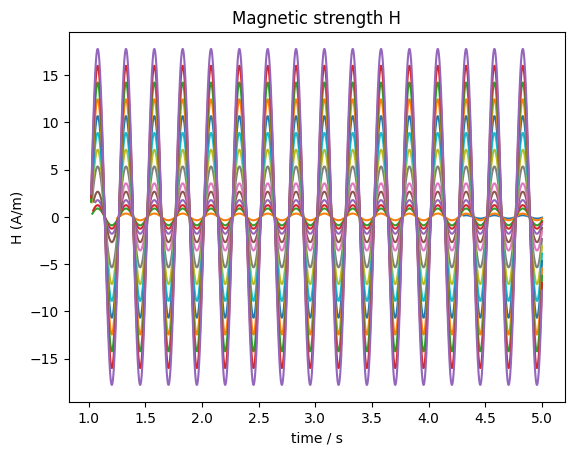

In [237]:
H = []
B = []
B_int = []
peaks_find = []
mean = []
for i in range(len(Vamp)):
    H.append(np.array(I[i]) * N / lc)         # Magnetic field strength
    plt.plot(time_mea[i],H[i])
    plt.xlabel("time / s")
    plt.ylabel("H (A/m)")
    plt.title("Magnetic strength H")

for i in range(len(Vamp)):
    dB = np.array(Vpick_mea[i])/Ac/N/gain
    Bini = [0]
    for a in dB:
        Bini.append(Bini[-1] + ( a ) * dt )
    B.append(Bini[1:])

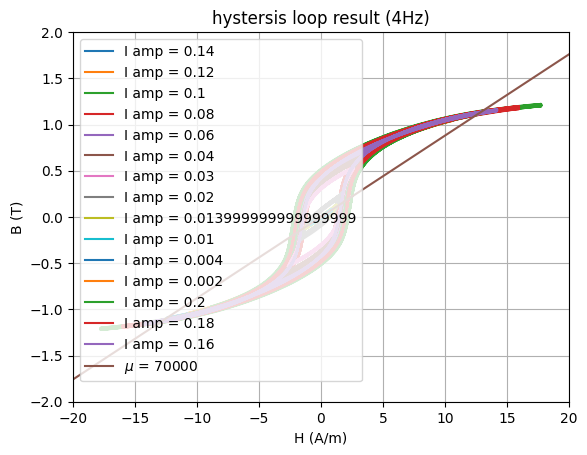

In [238]:
H_line = np.linspace(-20,20,12)
B_the = H_line * u
B_amped = []
for i in range(len(Vamp)):
    plt.plot(H[11-i],B[11-i]-(max(B[11-i])+min(B[11-i]))/2,'-', label = "I amp = " + str(Vamp[11-i]/50))
plt.plot(H_line,B_the, label = r"$\mu$ = 70000")
plt.xlim([-20,20])
plt.ylim([-2,2])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("hystersis loop result (4Hz)")
plt.grid(True)
plt.legend()

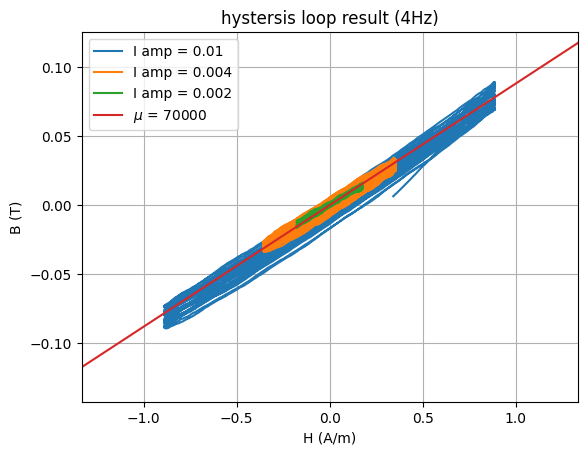

In [246]:
H_line = np.linspace(-10,10,12)
B_the = H_line * u
B_amped = []
plt_num = 2
for i in range(plt_num+1):
    plt.plot(H[plt_num-i],B[plt_num-i]-(max(B[plt_num-i])+min(B[plt_num-i]))/2,'-', label = "I amp = " + str(Vamp[plt_num-i]/50))
plt.plot(H_line,B_the, label = r"$\mu$ = 70000")
plt.xlim([min(H[plt_num])*1.5,max(H[plt_num])*1.5])
plt.ylim([min(B[plt_num])*1.5,max(B[plt_num])*1.5])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("hystersis loop result (4Hz)")
plt.grid(True)
plt.legend()

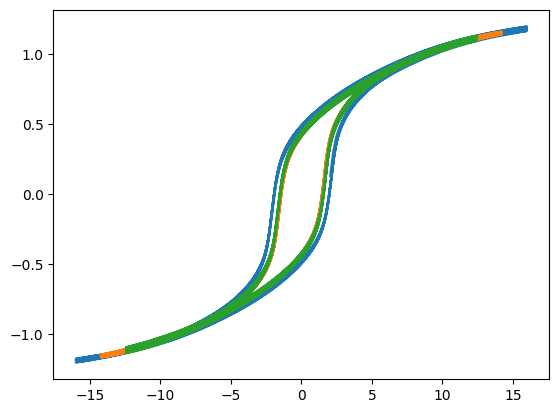

In [240]:
for i in [13,12,11]:
    plt.plot(H[i],B[i]-(max(B[i])+min(B[i]))/2,'-', label = "I amp = " + str(Vamp[i]/50))

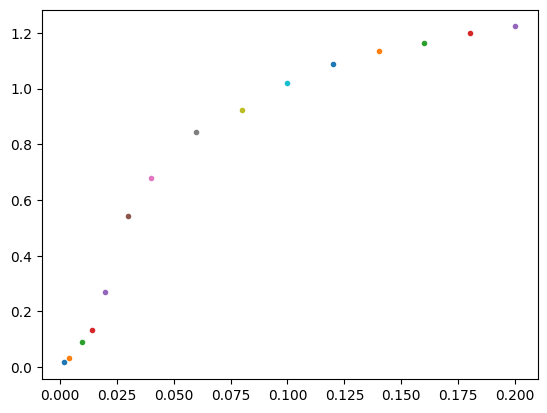

In [247]:
for i in range(len(Vamp)):
    plt.plot(Vamp[i]/50,(max(B[i])-min(B[i]))/2,'.-')